In [3]:
import numpy as np

import sys
sys.path.insert(0, '../src/easyesn/')

In [4]:
from easyesn import PredictionESN, BaseESN
from easyesn import helper as hlp
from easyesn.optimizers import GradientOptimizer
import matplotlib.pyplot as plt
import easyesn

np.random.seed(42)

In [6]:
#generate train/test data




"""
inputLength = 1000
trainingLength = int(inputLength*0.7)
data = np.linspace(0, 10*np.pi, inputLength).reshape(-1,1)
inputData = np.sin(data)
outputData = np.cos(data)
"""

inputData = np.loadtxt("ShinrikiX.txt").reshape((-1, 1))
outputData = inputData[84:]
inputData = inputData[:-84]


inputLength = len(inputData)
trainingLength = int(inputLength*0.7)

inputDataTraining = inputData[:trainingLength]
inputDataValidation = inputData[trainingLength:]

outputDataTraining = outputData[:trainingLength]
outputDataValidation = outputData[trainingLength:]

transientTime = 100
splitLength = 1000
overlapLength = 100
splitNumber = int(np.ceil(trainingLength / splitLength))

In [10]:
reservoirs = []
reservoirs.append(PredictionESN(n_input=1, n_output=1, n_reservoir=50, leakingRate=0.2, regressionParameters=[1e-2], solver="lsqr", feedback=False))

for i in range(splitNumber-1):
    reservoirs.append(PredictionESN(n_input=1, n_output=1, n_reservoir=50, leakingRate=0.2, regressionParameters=[1e-2], solver="lsqr", feedback=False))
    reservoirs[-1]._W = reservoirs[0]._W
    reservoirs[-1]._WInput = reservoirs[0]._WInput
    
states = np.empty((50 + 1 + 1, trainingLength))
for i in range(splitNumber):
    reservoirs[i].resetState()
    dataEnd = min((i+1) * splitLength, trainingLength)
    dataStart = max(0, i*splitLength - overlapLength)
    data = inputDataTraining[dataStart:dataEnd]
    stat = reservoirs[i].propagate(data)
    states[:, i*splitLength:dataEnd] = stat[:, 0 if i==0 else overlapLength:]

Y_target = outputDataTraining.T[:, transientTime:]

states = states[:, transientTime:]

X_T = states.T
_WOut = np.dot(np.dot(Y_target, X_T), np.linalg.inv(np.dot(states,X_T) + reservoirs[0]._regressionParameters[0]*np.identity(1+1+50)))

reservoirs[-1]._WOut = _WOut

In [11]:
prediction = reservoirs[-1].predict(inputDataValidation)

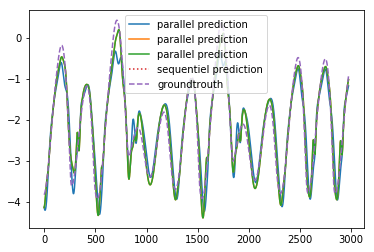

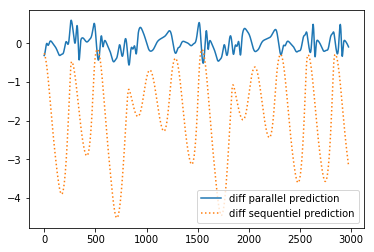

Par MSE = 0.0478330206665284
Seq MSE = 5.0095899766664


In [14]:
plt.plot(prediction, label="parallel prediction")
plt.plot(sequential_prediction, label="sequentiel prediction", ls=":")
plt.plot(outputDataValidation, label="groundtrouth", ls="--")
plt.legend()
plt.show()

plt.plot(prediction - outputDataValidation, label="diff parallel prediction")
plt.plot(sequential_prediction - outputDataValidation, label="diff sequentiel prediction", ls=":")
plt.legend()
plt.show()

print("Par MSE = {0}".format(np.mean((outputDataValidation - prediction)**2)))
print("Seq MSE = {0}".format(np.mean((outputDataValidation - sequential_prediction)**2)))

In [13]:
esn = PredictionESN(n_input=1, n_output=1, n_reservoir=50, leakingRate=0.2, regressionParameters=[1e-2], solver="lsqr", feedback=False)
esn.fit(inputDataTraining, outputDataTraining, transientTime="Auto", verbose=1)
sequential_prediction = esn.predict(inputDataValidation[0])

100% (1 of 1) |###########################| Elapsed Time: 0:00:00 Time: 0:00:00


In [76]:
len(reservoirs)

35